We would like to see how the k-d tree algorithm works. 

Honestly, I started building the Quadtree, but the generalization is straightforward, so I made the k-d tree . I follow the logic of [TheCodingTrain](https://www.youtube.com/c/TheCodingTrain) brilliant person. So, you can also watch the videos if you don't get what I am doing.

The k-d tree algorithm allows us to recursively partition space. You start with a cube, you measoure a property. If this property exceeds some value, then you subdivide the cube into smaller ones. Then you do the same for each cube until all cubes have a size such that property inside each cube is below some value.

The most wide-spread application is to partition the space into cubes, each one holding up to a given number of some input points. This is used to find nearest neighbours efficiently.

In [1]:
import numpy as np

import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Then, we need to define a square. There are a lot of ways we can define a square. Here, we will just use the center (just a point) and its distance form the boundary of the square. 

In [2]:
class Cube:
    def __init__(self,center,distance):
        self.center=center
        self.distance=distance
        self.dim=len(center)

        self.generate_signs()#this list will hep us move a point towards backwards and forward directions in all axes 

    def generate_signs(self):
        '''
        The code below generates a list of signs that will move a point to all posible directions.
        Example for 2 dimensions this will give us
        
        [
            [1,1],
            [1,-1],
            [-1,1],
            [-1,-1]
        ]
        
        In three dimensions  
        [
            [1, 1, 1],
            [1, 1, -1],
            [1, -1, 1],
            [1, -1, -1],
            [-1, 1, 1],
            [-1, 1, -1],
            [-1, -1, 1],
            [-1, -1, -1]
        ]
        
        I came up with this code by trying different things and simplifying the result.
        
        What you need to do to replicate it is to draw on a board what you wat to do:
        take all possible combinations od size=self.dim of a list of +1 and -1 (there are dim**2 combinations).
        What you need to do is understand how to do this:
        
        + +
        + -
        - +
        - -
        
        Then this
        + + +
        + + -
        + - +
        + - -
        - + +
        - + -
        - - +
        - - -
        
        Then the pattern emerges: the last one changes every 1 step the second to last every 2, third to last every 4. 
        Translate this into a for-loop, and you have your result :)
        '''
        self.signs=[[0 for __ in range(self.dim)] for _ in range(2**self.dim)]
        for j in range(self.dim):
            count=0
            for i in range(2**self.dim):
                self.signs[i][j]=(-1)**count
                if (i+1)%(2**(self.dim-1-j))==0:
                    count+=1
                    if count==2:
                        count=0 

    def check_point(self,point):
        '''check whether point is inside this square'''
        for i in range(self.dim):
            if point[i]>self.center[i]+self.distance or point[i]<self.center[i]-self.distance:
                return False
        
        return True

The tree needs to be constructed recursively when you count the points. So, we need a Quadtree class to keep track of these things. Without losing anything, we can make our entire space (the initial square) the unit square. If we need a bigger square, we just rescale everything between 0 and 1.

Each element of Dtree is a boundary (it is inside a cube) and has some capacity. So, this is the contructor.

In [3]:
class DTree:
    '''
    The DTree class recursively subdivides the space.
    '''
    def __init__(self,boundary,capacity):
        '''
        boundary: an instance of Cube. It is the cube that defines this "node" of the tree.
        capacity: how many points it can hold. If there are more points inside this cube, then
        subdivide it.
        '''
        
        #We deal with cubes, but use the dim when you can. It will be easier to generalize later.
        self.dim=boundary.dim
        
        self.boundary=boundary
        self.capacity=capacity
        
        self.points=[] #list of intances of Point. The points inside the cube.
        self.number_of_points=0
        
        #List of intances of DTree. This will hold the potential cubes.
        #Each instance of DTree has either 0 or dim**2 children.
        self.children=[0 for i in range(2**self.dim)]  
        self.has_children=False
        
                        
                        
    def subdivide(self):
        '''Subdivide the cube'''
        self.has_children=True
        new_distance = self.boundary.distance/2. #the distance of all new cubes
        for i in range(2**self.dim):
            new_center = [ self.boundary.signs[i][d]*new_distance + self.boundary.center[d] for d in range(self.dim)]
            child = Cube( new_center , new_distance )
            
            self.children[i]=DTree(child,self.capacity)
        
    
    def push(self,point):
        '''
        Add point in points.
        if the number of points exceeds self.capacity, subdivide.
        
        Returns True if the point is accepted and False if it is not
        '''
        
        #if this point is not inside the boundary, do nothing
        if not self.boundary.check_point(point):
            return False
        
        if self.number_of_points < self.capacity:
            self.points.append(point)
            self.number_of_points+=1
            
        else:
            '''if it already has children, do not subdivide'''
            if not self.has_children:
                self.subdivide()#subdivide the cube
                
                #fill the childern with all the points of this DTree 
                for p in self.get_points():
                    for i in range(2**self.dim):
                        if self.children[i].push(p):
                            break#if the point is accepted in this child, then go to the next point
                
                self.points=[]#empty this list

                
                
            for i in range(2**self.dim):
                if self.children[i].push(point):
                    break
        
        return True
        
    def get_points(self):
        '''Get the points of the tree and its children  recursively'''
        if self.has_children:
            points=[]
            for i in self.children:
                for p in i.get_points():
                    points.append(p)
            return points
        else:
            return self.points
        
        
        
        
    def get_cubes(self):
        '''Get the cubes of the tree and its children  recursively'''
        cubes=[self.boundary]
        if self.has_children:
            for i in self.children:
                for c in i.get_cubes():
                    cubes.append(c)
        return cubes

    def get_centers(self):
        '''Get the centers of the tree and its children  recursively'''
        centers=[self.boundary.center]
        if self.has_children:
            for i in self.children:
                for c in i.get_centers():
                    centers.append(c)
        return centers
    
    



You can make 1 dimensional objects

In [4]:
Qt=DTree(Cube([0.5],0.5),15)
for _ in range(1500):
    Qt.push([np.random.normal(0.5,0.1)])

<IPython.core.display.Javascript object>


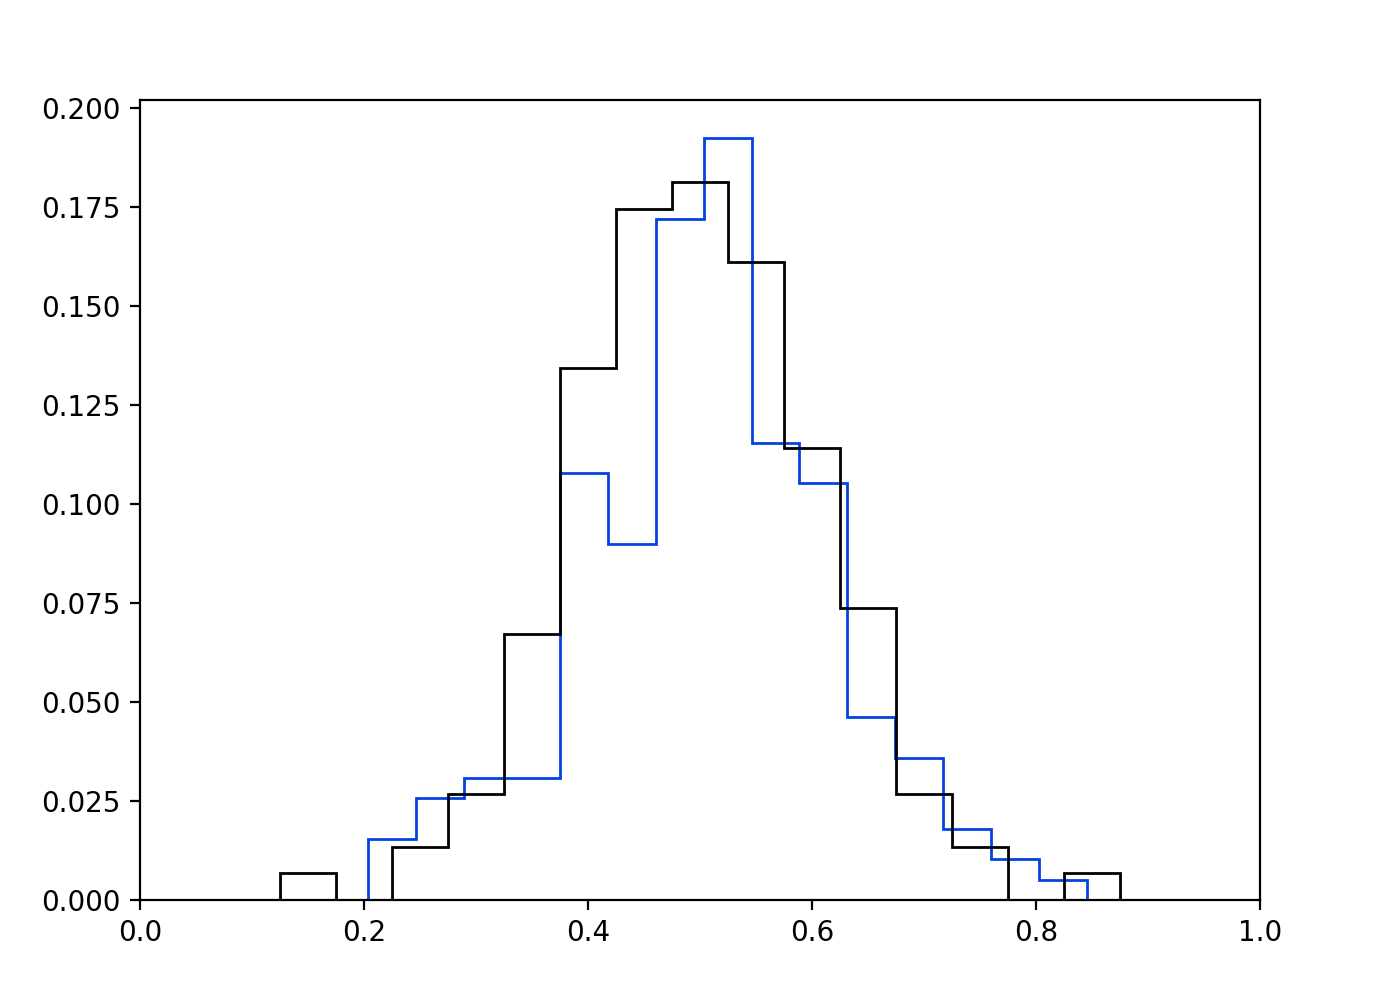

In [5]:
fig=plt.figure(figsize=(7,5))
fig.subplots_adjust(bottom=0.1, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.5)




sub = fig.add_subplot(111)

pp=np.array(Qt.get_points())
weights = np.ones_like(pp) / len(pp)
sub.hist(pp[:,0],color='xkcd:blue', histtype="step",weights=weights,bins=15)


cc=np.array(Qt.get_centers())
weights = np.ones_like(cc) / len(cc)
sub.hist(cc[:,0],color='xkcd:black', histtype="step",weights=weights,bins=15)





sub.set_xlim(0,1)
# sub.set_ylim(0,1) 
plt.show()

You can make 2 dimensional objects

In [6]:
Qt=DTree(Cube([0.5,0.5],0.5),10)

In [7]:
for _ in range(1500):
    cov = np.array([[0.1, 0.01], [0.01, 0.01]])
    r=np.random.multivariate_normal([0.5, 0.5], cov)

    Qt.push(r)


<IPython.core.display.Javascript object>


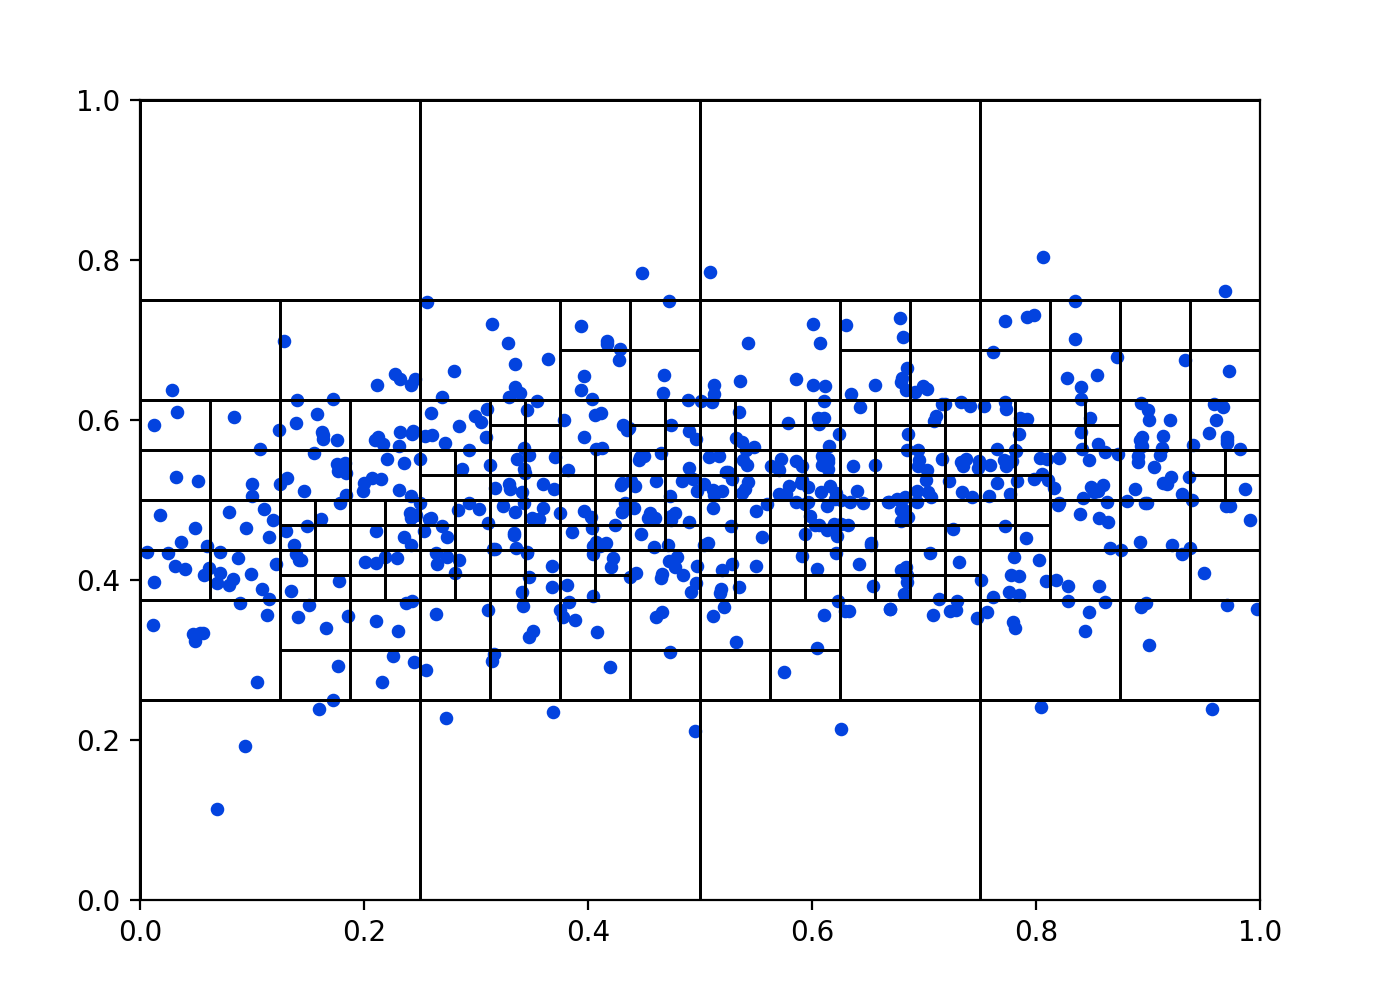

In [8]:
fig=plt.figure(figsize=(7,5))
fig.subplots_adjust(bottom=0.1, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.5)




sub = fig.add_subplot(111)

# cc=np.array(Qt.get_centers())
# sub.scatter(cc[:,0],cc[:,1],c='xkcd:black',s=15)
pp=np.array(Qt.get_points())
sub.scatter(pp[:,0],pp[:,1],c='xkcd:blue',s=15)


sq=np.array(Qt.get_cubes())
for _ in sq:
    sub.add_patch(
        Rectangle((_.center[0]-_.distance,_.center[1]-_.distance), _.distance*2, _.distance*2,
        facecolor='none',edgecolor='xkcd:black'),
    )




sub.set_xlim(0,1)
sub.set_ylim(0,1) 
plt.show()

You can make 3 dimensional objects

In [9]:
Qt=DTree(Cube([0.5,0.5,0.5],0.5),30)

In [10]:
for _ in range(5000):

    Qt.push([np.random.normal(0.3,0.02),np.random.normal(0.5,0.1),np.random.normal(0.5,0.3)])


<IPython.core.display.Javascript object>


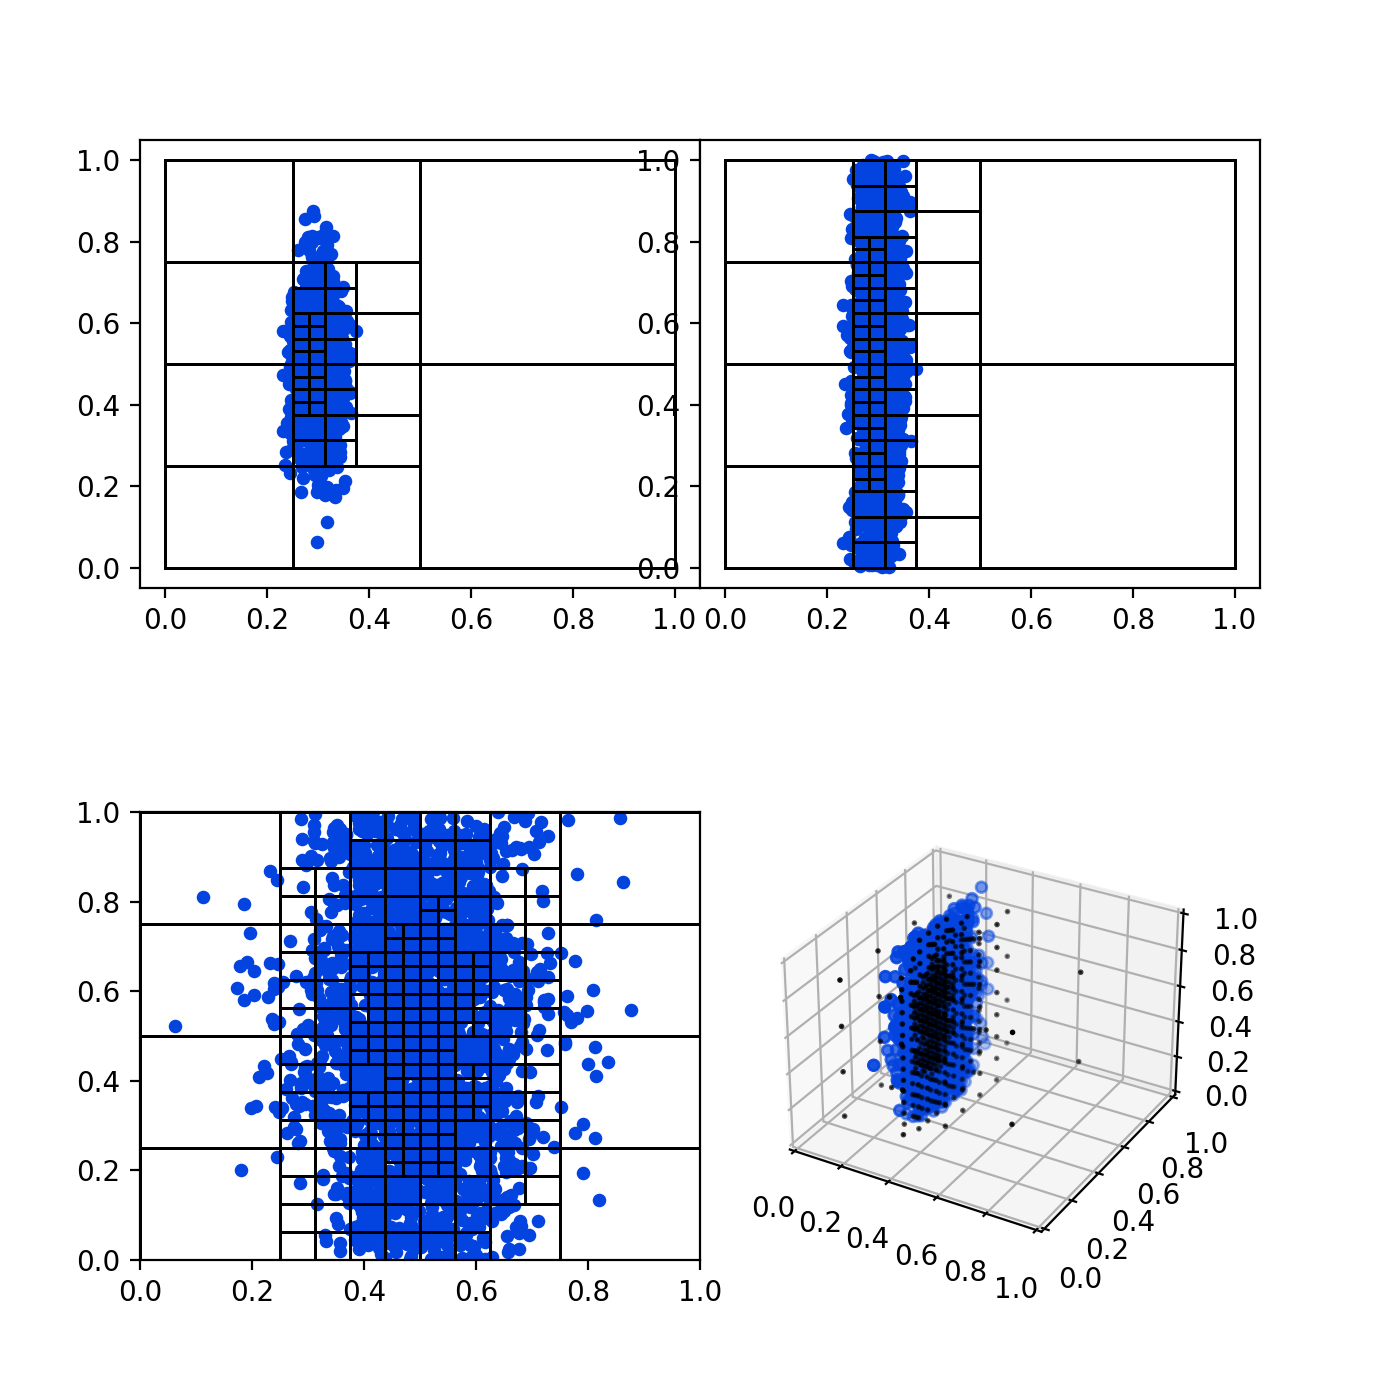

In [11]:
fig=plt.figure(figsize=(7,7))
fig.subplots_adjust(bottom=0.1, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.5)




pp=np.array(Qt.get_points())
sq=np.array(Qt.get_cubes())
cc=np.array(Qt.get_centers())

sub = fig.add_subplot(221)
sub.scatter(pp[:,0],pp[:,1],c='xkcd:blue',s=15)
for _ in sq:
    sub.add_patch(
        Rectangle((_.center[0]-_.distance,_.center[1]-_.distance), _.distance*2, _.distance*2,
        facecolor='none',edgecolor='xkcd:black'),
    )
sub = fig.add_subplot(222)
sub.scatter(pp[:,0],pp[:,2],c='xkcd:blue',s=15)
for _ in sq:
    sub.add_patch(
        Rectangle((_.center[0]-_.distance,_.center[2]-_.distance), _.distance*2, _.distance*2,
        facecolor='none',edgecolor='xkcd:black'),
    )
sub = fig.add_subplot(223)
sub.scatter(pp[:,1],pp[:,2],c='xkcd:blue',s=15)
for _ in sq:
    sub.add_patch(
        Rectangle((_.center[1]-_.distance,_.center[2]-_.distance), _.distance*2, _.distance*2,
        facecolor='none',edgecolor='xkcd:black'),
    )
sub.set_xlim(0,1)
sub.set_ylim(0,1) 


sub = fig.add_subplot(224,projection='3d')
sub.scatter(cc[:,0],cc[:,1],cc[:,2],c='xkcd:black',s=1)
sub.scatter(pp[:,0],pp[:,1],pp[:,2],c='xkcd:blue',s=15)
sub.set_xlim(0,1)
sub.set_ylim(0,1) 
sub.set_zlim(0,1) 



plt.show()

You can make 4 dimensional objects.
The projections can be misleading because a point may be inside the projected plane, but it may be in different cubes in the perpenticular directions. This can lead to undivided squares with large number of points.

In [12]:
Qt4=DTree(Cube([0.5,0.5,0.5,0.5],0.5),15)

In [13]:
for _ in range(5000):
    cov = np.array([[0.1, 0.05], [0.05, 0.1]])
    r=np.random.multivariate_normal([0.5, 0.5], cov)
    Qt4.push([np.random.normal(0.3,0.02),np.random.normal(0.5,0.1),r[0],r[1]])
#     Qt4.push(np.random.normal(0.3,0.1,size=4))
#     Qt4.push([0.2,0.2,0.2,0.5])


<IPython.core.display.Javascript object>


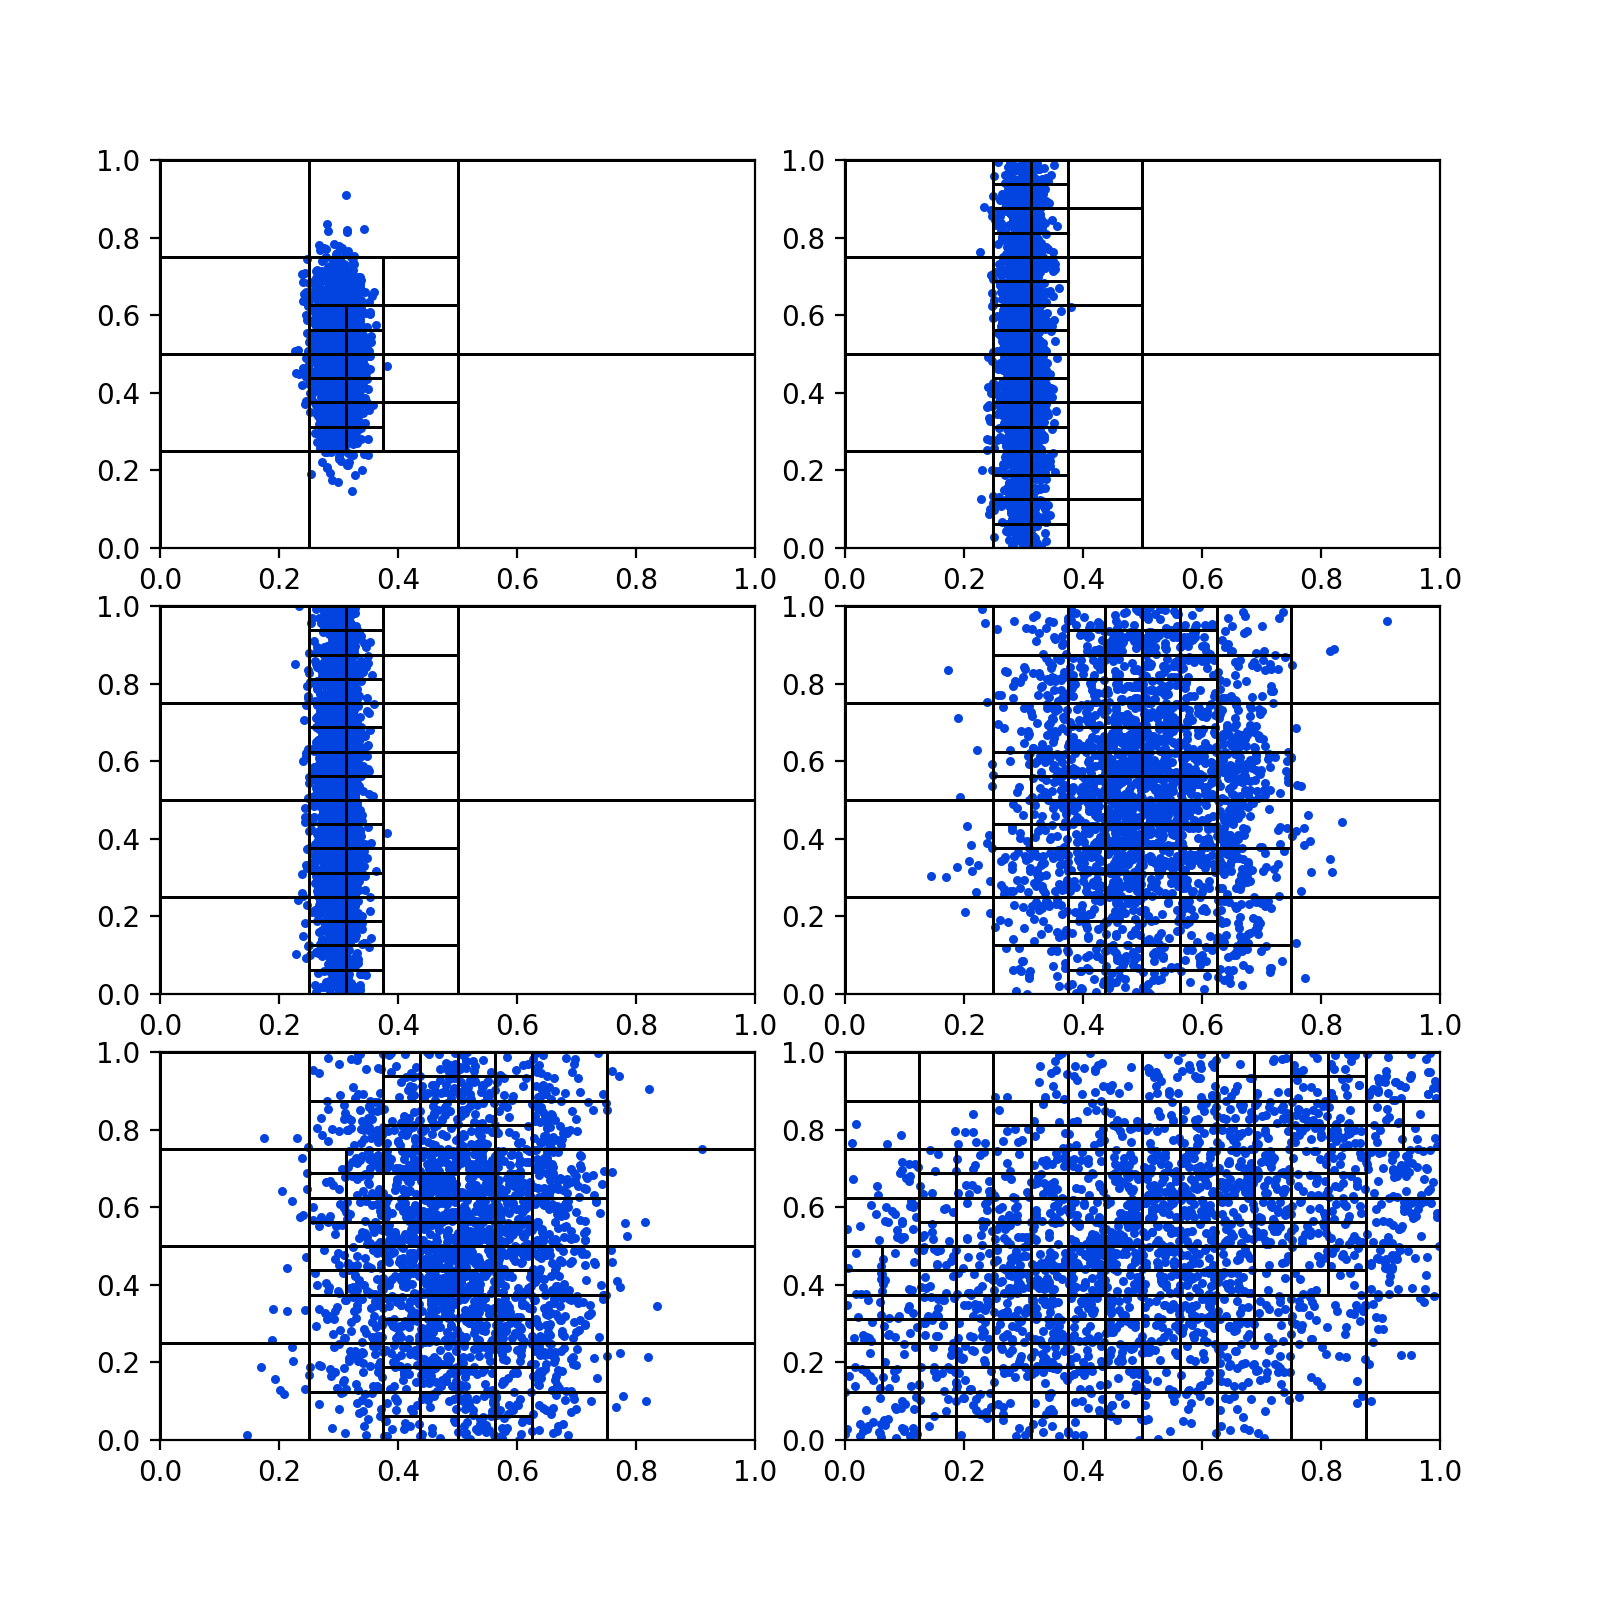

In [14]:
fig=plt.figure(figsize=(8,8))
fig.subplots_adjust(bottom=0.1, left=0.1, top = 0.9, right=0.9,wspace=0.15,hspace=0.15)




pp=np.array(Qt4.get_points())
sq=np.array(Qt4.get_cubes())
cc=np.array(Qt4.get_centers())

sub = fig.add_subplot(321)
i=0
j=1

sub.scatter(pp[:,i],pp[:,j],c='xkcd:blue',s=5)
for _ in sq:
    sub.add_patch(
        Rectangle((_.center[i]-_.distance,_.center[j]-_.distance), _.distance*2, _.distance*2,
        facecolor='none',edgecolor='xkcd:black'),
    )
    
sub.set_xlim(0,1)
sub.set_ylim(0,1) 
#sub.axis('off')
  
sub = fig.add_subplot(322)
i=0
j=2

sub.scatter(pp[:,i],pp[:,j],c='xkcd:blue',s=5)
for _ in sq:
    sub.add_patch(
        Rectangle((_.center[i]-_.distance,_.center[j]-_.distance), _.distance*2, _.distance*2,
        facecolor='none',edgecolor='xkcd:black'),
    )
sub.set_xlim(0,1)
sub.set_ylim(0,1) 
#sub.axis('off')
    
sub = fig.add_subplot(323)
i=0
j=3

sub.scatter(pp[:,i],pp[:,j],c='xkcd:blue',s=5)
for _ in sq:
    sub.add_patch(
        Rectangle((_.center[i]-_.distance,_.center[j]-_.distance), _.distance*2, _.distance*2,
        facecolor='none',edgecolor='xkcd:black'),
    )
sub.set_xlim(0,1)
sub.set_ylim(0,1) 
#sub.axis('off')

sub = fig.add_subplot(324)
i=1
j=2

sub.scatter(pp[:,i],pp[:,j],c='xkcd:blue',s=5)
for _ in sq:
    sub.add_patch(
        Rectangle((_.center[i]-_.distance,_.center[j]-_.distance), _.distance*2, _.distance*2,
        facecolor='none',edgecolor='xkcd:black'),
    )
sub.set_xlim(0,1)
sub.set_ylim(0,1) 
#sub.axis('off')

sub = fig.add_subplot(325)
i=1
j=3

sub.scatter(pp[:,i],pp[:,j],c='xkcd:blue',s=5)
for _ in sq:
    sub.add_patch(
        Rectangle((_.center[i]-_.distance,_.center[j]-_.distance), _.distance*2, _.distance*2,
        facecolor='none',edgecolor='xkcd:black'),
    )
sub.set_xlim(0,1)
sub.set_ylim(0,1) 
#sub.axis('off')

sub = fig.add_subplot(326)
i=2
j=3

sub.scatter(pp[:,i],pp[:,j],c='xkcd:blue',s=5)
for _ in sq:
    sub.add_patch(
        Rectangle((_.center[i]-_.distance,_.center[j]-_.distance), _.distance*2, _.distance*2,
        facecolor='none',edgecolor='xkcd:black'),
    )

    
    
sub.set_xlim(0,1)
sub.set_ylim(0,1) 
#sub.axis('off')


plt.show()